# Analiza gaming platformi: PC vs konzole

## Uvod
Gaming industrija danas je jedan od najvažnijih segmenata zabavne industrije, sa značajnim utjecajem na globalnu ekonomiju, kulturu i tehnologiju. Uz godišnje prihode koji premašuju prihode filmske i glazbene industrije zajedno, gaming nije samo oblik zabave, već i pokretač tehnoloških inovacija. Platforme poput PC-ja, konzola i mobilnih uređaja igraju ključnu ulogu u oblikovanju ove industrije, svaka s jedinstvenim karakteristikama koje privlače različite skupine igrača.

Razlike između ovih platformi postale su predmet interesa ne samo igrača nego i analitičara, koji nastoje razumjeti obrasce ponašanja korisnika, preferencije prema igrama te globalne trendove. Dok PC ostaje platforma koja nudi najveću prilagodljivost i tehničke mogućnosti, konzole poput PlayStationa i Xboxa nastoje pružiti integrirano iskustvo i ekskluzivne naslove koji privlače milijune igrača. Mobilne igre, s druge strane, bilježe eksplozivan rast zahvaljujući dostupnosti i širokoj bazi korisnika.

Cilj ovog istraživanja je analizirati popularnost gaming platformi kroz podatke o prodaji, aktivnim igračima i globalnim trendovima pretraživanja. Kombiniranjem informacija iz više izvora, kao što su Steam API, Kaggle, VGChartz i Google Trends, namjeravamo dobiti cjelovit uvid u trenutne preferencije tržišta i predvidjeti potencijalne buduće promjene.

Jedna napomena samo jest da kod prijave teme sam krivo shvatio značenje aplikacije te sam zato naveo steamlit za izradu aplikacije. A neće se koristiti već će se koristiti REST API.

## Motivacija
Za motivacije oduvijek me je zanimalo koja je gaming platforma najpopularnija, bilo da je riječ o PC-ju, PlayStationu ili Xboxu. Ove platforme često izazivaju rasprave među igračima o tome koja pruža najbolje iskustvo i koja ima najveći utjecaj na industriju. Također, fascinirala me ideja o tome koja igra dominira na svim platformama – postoji li naslov koji univerzalno privlači igrače bez obzira na njihov odabir uređaja? Ovo istraživanje pruža priliku da se dublje analizira popularnost platformi i igara, temeljeno na stvarnim podacima o prodaji, trendovima i broju aktivnih korisnika, kako bi se odgovorilo na ova pitanja i bolje razumjelo trenutno stanje gaming svijeta.

## Početak koda


In [1]:
!pip install requests pandas matplotlib kaggle
!pip install tabulate
!pip install Flask SQLAlchemy
!pip install streamlit
!pip install plotly
!pip install fastapi sqlalchemy uvicorn



In [2]:
import pandas as pd
import requests
import json
from tabulate import tabulate
import os
import plotly.express as px
from sqlalchemy import create_engine, text
import logging
import uvicorn
from threading import Thread
import nest_asyncio
from fastapi import FastAPI
from IPython.display import display
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Preuzimanje datasetova  
### Kaggle dataset
Prvi podaci su preuzeti s platforme Kaggle, poznate baze podataka i alata za znanstveno računanje. Koristio sam dataset pod nazivom "Video Game Sales", koji pruža informacije o prodaji videoigara na globalnoj razini. Dataset uključuje informacije o nazivima igara, platformama, godinama izdavanja, prodaji po regijama i drugim sličnim značajkama. Podaci su prethodno prikupljeni od strane autora dataseta te su javno dostupni za analizu i istraživanje. Ovaj dataset je preuzet kao .csv datoteka te je uplodan u isti direktorij gdje se nalazi trenutna datoteka.

Kaggle dataset:
Gregorut. (n.d.). Video Game Sales. Kaggle. Retrieved January 24, 2025, from https://www.kaggle.com/datasets/gregorut/videogamesales

In [3]:
file_name = 'vgsales.csv'

df = pd.read_csv(file_name)

print(df.head())

   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  


### RAWG API 
Drugi podaci preuzeti su putem RAWG API-ja. Te spremljeni su u.json datoteku u isti direktorij kao i trenutni dokument. RAWG je najveća baza podataka o videoigrama koja nudi informacije poput ocjena igara, žanrova, dostupnih platformi i datuma izdavanja. Podaci su prikupljeni putem zahtjeva prema API-ju pomoću knjižnice requests u Pythonu. API nudi dinamičan pristup informacijama o igrama, a podaci su filtrirani i obrađeni prema potrebama analize. Te do podataka se došlo uz pomoć generiranog API ključa.

RAWG API:
RAWG.io. (n.d.). RAWG Video Games Database API. Retrieved January 24, 2025, from https://rawg.io/apidocs

Preuzeto je do max 5000 linija zbog dugog čekanja na izvršavanje komande.


In [3]:
api_key = "379252d816164c0d88901df04a31a926"

# preuzimanje podataka te stavio sam si limit na 5000 jer predugo traje inace ide u nedogled
def get_all_rawg_data(limit=5000):
    base_url = "https://api.rawg.io/api/games"
    all_data = []
    page = 1
    while True:
        params = {
            "page": page,   
            "page_size": 40,   # Broj rezultata po stranici
            "key": api_key     
        }
        response = requests.get(base_url, params=params)
        
        # pprovjera
        if response.status_code != 200:
            print(f"Greška pri dohvaćanju podataka: {response.status_code}")
            break
        
        data = response.json()

        # Provjera postoji li podatak
        if "results" not in data:
            print("Nema podataka u odgovoru.")
            break
        
        # Dodaj igre iz ove stranice
        all_data.extend(data["results"])  
        page += 1
        
        print(f"Preuzeta stranica {page}, ukupno preuzeto {len(all_data)} igara.")
        
        if len(all_data) >= limit:
            print(f"Dostignut limit od {limit} igara.")
            break

        if not data.get("next"):
            break

    return all_data

rawg_data = get_all_rawg_data(limit=5000)

with open('rawg_data_all.json', 'w') as json_file:
    json.dump(rawg_data, json_file, indent=4)

print(f"Preuzeto {len(rawg_data)} igara. Podaci su spremljeni u 'rawg_data_all.json'.")

Preuzeta stranica 2, ukupno preuzeto 40 igara.
Preuzeta stranica 3, ukupno preuzeto 80 igara.
Preuzeta stranica 4, ukupno preuzeto 120 igara.
Preuzeta stranica 5, ukupno preuzeto 160 igara.
Preuzeta stranica 6, ukupno preuzeto 200 igara.
Preuzeta stranica 7, ukupno preuzeto 240 igara.
Preuzeta stranica 8, ukupno preuzeto 280 igara.
Preuzeta stranica 9, ukupno preuzeto 320 igara.
Preuzeta stranica 10, ukupno preuzeto 360 igara.
Preuzeta stranica 11, ukupno preuzeto 400 igara.
Preuzeta stranica 12, ukupno preuzeto 440 igara.
Preuzeta stranica 13, ukupno preuzeto 480 igara.
Preuzeta stranica 14, ukupno preuzeto 520 igara.
Preuzeta stranica 15, ukupno preuzeto 560 igara.
Preuzeta stranica 16, ukupno preuzeto 600 igara.
Preuzeta stranica 17, ukupno preuzeto 640 igara.
Preuzeta stranica 18, ukupno preuzeto 680 igara.
Preuzeta stranica 19, ukupno preuzeto 720 igara.
Preuzeta stranica 20, ukupno preuzeto 760 igara.
Preuzeta stranica 21, ukupno preuzeto 800 igara.
Preuzeta stranica 22, ukupno p

## Pretprocesiranje i čišćenje podataka

Prikupljeni podaci iz oba izvora zahtijevali su detaljno pretprocesiranje prije integracije. Podaci iz Kaggle skupa prošli su pregled kako bi se uklonili duplicirani zapisi i zapisi s nedostajućim ključnim vrijednostima, poput naziva igre, platforme i godine. S druge strane, podaci dohvaćeni iz RAWG API-ja su filtrirani tako da sadrže samo relevantne informacije poput naziva igre, platformi i korisničkih ocjena, a platforme su također standardizirane kako bi odgovarale formatima u Kaggle datasetu. .Pregledavaju se spremljeni podatci. Te se uzimaju samo oni koji su potrebni u daljnoj analizi. A to su naziv igrice, datum izlaska, ocjena, platforme na kojim je dostupna igrica.


In [4]:
duplicate_count = df.duplicated().sum()
print(f"Broj dupliciranih zapisa: {duplicate_count}")

if duplicate_count > 0:
    duplicates = df[df.duplicated()]
    print("Duplicirani zapisi:")
    print(duplicates)

Broj dupliciranih zapisa: 0


In [5]:
missing_values = df.isnull().sum()
print("Broj nedostajućih vrijednosti po stupcima:")
print(missing_values)

missing_keys = df[df['Name'].isnull() | df['Platform'].isnull()]
print(f"Broj zapisa s nedostajućim vrijednostima u ključnim stupcima (Name, Platform): {len(missing_keys)}")

if not missing_keys.empty:
    print("Zapisi s nedostajućim ključnim vrijednostima:")
    print(missing_keys)

Broj nedostajućih vrijednosti po stupcima:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64
Broj zapisa s nedostajućim vrijednostima u ključnim stupcima (Name, Platform): 0


In [6]:
with open('rawg_data_all.json', 'r', encoding='utf-8') as file:
    rawg_data = json.load(file)

# Ispis detaljnih informacija o preuzetim igrama
if rawg_data:
    print(f"Detaljni podaci o preuzetim igrama (ukupno {len(rawg_data)}):\n")
    print(f"{'ID':<10} {'Naziv':<40} {'Datum izlaska':<15} {'Ocjena':<10} {'Platforme'}")
    print("-" * 100)
    
    for idx, game in enumerate(rawg_data[:200]): 
        game_id = game.get('id', 'N/A')
        name = game.get('name', 'N/A')
        released = game.get('released', 'N/A')
        rating = game.get('rating', 'N/A')
        platforms = ", ".join([p['platform']['name'] for p in game.get('platforms', []) if p.get('platform')]) 
        print(f"{game_id:<10} {name:<40} {released:<15} {rating:<10} {platforms}")
else:
    print("Nema preuzetih podataka.")


Detaljni podaci o preuzetim igrama (ukupno 5000):

ID         Naziv                                    Datum izlaska   Ocjena     Platforme
----------------------------------------------------------------------------------------------------
3498       Grand Theft Auto V                       2013-09-17      4.47       PC, PlayStation 5, Xbox Series S/X, PlayStation 4, PlayStation 3, Xbox 360, Xbox One
3328       The Witcher 3: Wild Hunt                 2015-05-18      4.65       Xbox Series S/X, PlayStation 5, macOS, PlayStation 4, Nintendo Switch, PC, Xbox One
4200       Portal 2                                 2011-04-18      4.6        PlayStation 3, PC, Xbox 360, Linux, macOS, Xbox One
4291       Counter-Strike: Global Offensive         2012-08-21      3.57       PC, Linux, Xbox 360, PlayStation 3
5286       Tomb Raider (2013)                       2013-03-05      4.06       PlayStation 4, PlayStation 3, Xbox 360, macOS, PC, Xbox One
13536      Portal                               

Gledamo je li su svi podatci uspješno učitani.

In [7]:
print("Kaggle dataset (Top 20 redaka):")
print(tabulate(df.head(20), headers='keys', tablefmt='pretty', showindex=False))

# Ispis RAWG dataset-a
print("\nRAWG dataset (Top 20 redaka):")
print(f"{'ID':<10} {'Naziv':<40} {'Datum izlaska':<15} {'Ocjena':<10} {'Platforme'}")
print("-" * 100)

# Ispis podataka o igrama iz rawg_data
for game in rawg_data[:20]: 
    game_id = game.get('id', 'N/A')
    name = game.get('name', 'N/A')
    released = game.get('released', 'N/A')
    rating = game.get('rating', 'N/A')

    platforms = ", ".join([p['platform']['name'] for p in game.get('platforms', []) if p.get('platform')])
    
    print(f"{game_id:<10} {name:<40} {released:<15} {rating:<10} {platforms}")


Kaggle dataset (Top 20 redaka):
+------+----------------------------------------------+----------+--------+--------------+------------------------+----------+----------+----------+-------------+--------------+
| Rank |                     Name                     | Platform |  Year  |    Genre     |       Publisher        | NA_Sales | EU_Sales | JP_Sales | Other_Sales | Global_Sales |
+------+----------------------------------------------+----------+--------+--------------+------------------------+----------+----------+----------+-------------+--------------+
|  1   |                  Wii Sports                  |   Wii    | 2006.0 |    Sports    |        Nintendo        |  41.49   |  29.02   |   3.77   |    8.46     |    82.74     |
|  2   |              Super Mario Bros.               |   NES    | 1985.0 |   Platform   |        Nintendo        |  29.08   |   3.58   |   6.81   |    0.77     |    40.24     |
|  3   |                Mario Kart Wii                |   Wii    | 2008.0 |   

Brišemo stupce iz .csv datoteke jer nam nisu bitni za daljnju analizu.

In [8]:
df = df.drop(columns=['Publisher','Year'])

print("Kaggle dataset bez stupca 'publisher':")
print(tabulate(df.head(10), headers='keys', tablefmt='pretty', showindex=False))

Kaggle dataset bez stupca 'publisher':
+------+---------------------------+----------+--------------+----------+----------+----------+-------------+--------------+
| Rank |           Name            | Platform |    Genre     | NA_Sales | EU_Sales | JP_Sales | Other_Sales | Global_Sales |
+------+---------------------------+----------+--------------+----------+----------+----------+-------------+--------------+
|  1   |        Wii Sports         |   Wii    |    Sports    |  41.49   |  29.02   |   3.77   |    8.46     |    82.74     |
|  2   |     Super Mario Bros.     |   NES    |   Platform   |  29.08   |   3.58   |   6.81   |    0.77     |    40.24     |
|  3   |      Mario Kart Wii       |   Wii    |    Racing    |  15.85   |  12.88   |   3.79   |    3.31     |    35.82     |
|  4   |     Wii Sports Resort     |   Wii    |    Sports    |  15.75   |  11.01   |   3.28   |    2.96     |     33.0     |
|  5   | Pokemon Red/Pokemon Blue  |    GB    | Role-Playing |  11.27   |   8.89   |  

Ponovo gledamo jesu li podatci spremni za daljnu obradu tako što ih prikazujemo u tablici.

In [9]:
print("Kaggle dataset (Top 20 redaka):")
print(tabulate(df.head(20), headers='keys', tablefmt='pretty', showindex=False))
print("\nRAWG dataset (Top 20 redaka):")
print(f"{'ID':<10} {'Naziv':<40} {'Datum izlaska':<15} {'Ocjena':<10} {'Platforme'}")
print("-" * 100)

for game in rawg_data[:20]:
    game_id = game.get('id', 'N/A')
    name = game.get('name', 'N/A')
    released = game.get('released', 'N/A')
    rating = game.get('rating', 'N/A')
    
    platforms = ", ".join([p['platform']['name'] for p in game.get('platforms', []) if p.get('platform')])
    
    print(f"{game_id:<10} {name:<40} {released:<15} {rating:<10} {platforms}")


Kaggle dataset (Top 20 redaka):
+------+----------------------------------------------+----------+--------------+----------+----------+----------+-------------+--------------+
| Rank |                     Name                     | Platform |    Genre     | NA_Sales | EU_Sales | JP_Sales | Other_Sales | Global_Sales |
+------+----------------------------------------------+----------+--------------+----------+----------+----------+-------------+--------------+
|  1   |                  Wii Sports                  |   Wii    |    Sports    |  41.49   |  29.02   |   3.77   |    8.46     |    82.74     |
|  2   |              Super Mario Bros.               |   NES    |   Platform   |  29.08   |   3.58   |   6.81   |    0.77     |    40.24     |
|  3   |                Mario Kart Wii                |   Wii    |    Racing    |  15.85   |  12.88   |   3.79   |    3.31     |    35.82     |
|  4   |              Wii Sports Resort               |   Wii    |    Sports    |  15.75   |  11.01   | 

Integracija podataka iz ova dva izvora provedena je spajanjem na temelju zajedničkog atributa, naziva igre. Za povezivanje podataka korištena je funkcija merge iz Pandas biblioteke, gdje je naziv igre iz Kaggle skupa (stupac "Name") uspoređen s nazivom igre iz RAWG podataka (stupac "name"). Kako bi spajanje bilo uspješno, oba su atributa prethodno normalizirana. Rezultat ovog procesa je objedinjeni skup podataka koji uključuje informacije o globalnoj prodaji igara iz Kaggle skupa te korisničke ocjene i popis platformi iz RAWG API-ja. Konačni skup podataka dodatno je očišćen uklanjanjem svih zapisa s nedostajućim vrijednostima te onima koji nisu pootrebni u daljnoj analizi poput slug, background-image i sl.

Ovaj proces prikupljanja, čišćenja i spajanja podataka omogućio je stvaranje sveobuhvatnog skupa podataka koji obuhvaća detaljne informacije o igrama iz više izvora, pružajući temelj za daljnju analizu i vizualizaciju.

## Spajanje u jedan dataset

In [10]:
# pretvaram u df dva prijasnja kako bi bili jedan
rawg_df = pd.DataFrame(rawg_data)
kaggle_df = pd.DataFrame(df)

# Normalizacija naziva igara
rawg_df['name'] = rawg_df['name'].str.strip().str.lower()
kaggle_df['Name'] = kaggle_df['Name'].str.strip().str.lower()

# Spajanje podataka prema zajedničkom nazivu igre
merged_data = pd.merge(rawg_df, kaggle_df, left_on='name', right_on='Name', how='inner')

# Uklanjanje zapisa s nedostajućim vrijednostima u ključnim atributima
key_columns = ['Global_Sales', 'rating']  # Primjer ključnih atributa
merged_data = merged_data.dropna(subset=key_columns)

print(merged_data.head())


     id                slug                name    released    tba  \
0  3498  grand-theft-auto-v  grand theft auto v  2013-09-17  False   
1  3498  grand-theft-auto-v  grand theft auto v  2013-09-17  False   
2  3498  grand-theft-auto-v  grand theft auto v  2013-09-17  False   
3  3498  grand-theft-auto-v  grand theft auto v  2013-09-17  False   
4  3498  grand-theft-auto-v  grand theft auto v  2013-09-17  False   

                                    background_image  rating  rating_top  \
0  https://media.rawg.io/media/games/20a/20aa03a1...    4.47           5   
1  https://media.rawg.io/media/games/20a/20aa03a1...    4.47           5   
2  https://media.rawg.io/media/games/20a/20aa03a1...    4.47           5   
3  https://media.rawg.io/media/games/20a/20aa03a1...    4.47           5   
4  https://media.rawg.io/media/games/20a/20aa03a1...    4.47           5   

                                             ratings  ratings_count  ...  \
0  [{'id': 5, 'title': 'exceptional', 'count':

Pregledavamo sve stupce te brišemo one koji su nam nepotrebni

In [11]:
print("Stupci u merganom datasetu:")
print(merged_data.columns.tolist())

Stupci u merganom datasetu:
['id', 'slug', 'name', 'released', 'tba', 'background_image', 'rating', 'rating_top', 'ratings', 'ratings_count', 'reviews_text_count', 'added', 'added_by_status', 'metacritic', 'playtime', 'suggestions_count', 'updated', 'user_game', 'reviews_count', 'saturated_color', 'dominant_color', 'platforms', 'parent_platforms', 'genres', 'stores', 'clip', 'tags', 'esrb_rating', 'short_screenshots', 'community_rating', 'Rank', 'Name', 'Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']


In [12]:
stupci_za_uklanjanje = ['slug', 'tba', 'background_image','rating_top','ratings_count','reviews_text_count','community_rating','added','added_by_status','metacritic','playtime','suggestions_count','updated','user_game','reviews_count','saturated_color','dominant_color','parent_platforms','stores','clip','tags','esrb_rating','short_screenshots','Rank','ratings','platforms','genres','name']

merged_data = merged_data.drop(columns=stupci_za_uklanjanje)

print("Preostali stupci nakon uklanjanja:")
print(merged_data.columns.tolist())

Preostali stupci nakon uklanjanja:
['id', 'released', 'rating', 'Name', 'Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']


Provjeravamo dobiveni dataframe

In [13]:
print(merged_data.head()) 

     id    released  rating                Name Platform   Genre  NA_Sales  \
0  3498  2013-09-17    4.47  grand theft auto v      PS3  Action      7.01   
1  3498  2013-09-17    4.47  grand theft auto v     X360  Action      9.63   
2  3498  2013-09-17    4.47  grand theft auto v      PS4  Action      3.80   
3  3498  2013-09-17    4.47  grand theft auto v     XOne  Action      2.66   
4  3498  2013-09-17    4.47  grand theft auto v       PC  Action      0.36   

   EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0      9.27      0.97         4.14         21.40  
1      5.31      0.06         1.38         16.38  
2      5.81      0.36         2.02         11.98  
3      2.01      0.00         0.41          5.08  
4      0.64      0.00         0.08          1.08  


## Kreiranje baze podataka i spremanje dataseta

Nakon filtriranja podataka prema odabranim kriterijima, cilj je pohraniti te filtrirane podatke u bazu podataka kako bi ih bilo moguće kasnije analizirati ili koristiti. U ovom slučaju, baza podataka u kojoj će podaci biti pohranjeni zove se igre_baza.db, a nalazi se u istom direktoriju gdje se nalazi i trenutna mapa s izvršnim skriptama.
Kod za povezivanje na SQLite bazu koristi create_engine funkciju iz biblioteke sqlalchemy, koja omogućava stvaranje ili povezivanje na SQLite bazu podataka. 

U ovom primjeru, veza na bazu ostvarena je s nazivom sqlite:///igre_baza.db, što označava da će se baza nalaziti u trenutnom radnom direktoriju. Nakon toga, izvršava se SQL upit za dohvat svih podataka iz tablice igre. Nakon kreirane baze podataka još samo preostaje izrada REST API-a te vizualizacija podataka, što je sljedeći korak. 

In [14]:
# Kreiranje ili povezivanje na SQLite bazu podataka
DATABASE_PATH = os.path.join(os.getcwd(), "igre_baza.db")
engine = create_engine(f"sqlite:///{DATABASE_PATH}")

# dohvacam podatke vraca mi error
def fetch_data():
    return merged_data 
    
#kreiram si tablicu
def create_table_if_not_exists():
    try:
        with engine.connect() as connection:
            query = """
                CREATE TABLE IF NOT EXISTS igre (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    Name TEXT,
                    Platform TEXT,
                    Genre TEXT,
                    Global_Sales REAL
                );
            """
            connection.execute(text(query))
            print("Tablica 'igre' je uspješno stvorena ili već postoji.")
    except Exception as e:
        print(f"Greška pri kreiranju tablice: {str(e)}")

def insert_data_into_table(df):
    try:
        # ovdje unosim podatke
        with engine.connect() as connection:
            df.to_sql('igre', con=connection, if_exists='replace', index=False)
            print("Podaci su uspješno uneseni u tablicu 'igre'.")
    except Exception as e:
        print(f"Greška pri unosu podataka: {str(e)}")

create_table_if_not_exists()

merged_data = fetch_data()

insert_data_into_table(merged_data)

with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM igre"))
    
    for row in result:
        print(row)  # Ispis podataka iz tablice


Tablica 'igre' je uspješno stvorena ili već postoji.
Podaci su uspješno uneseni u tablicu 'igre'.
(3498, '2013-09-17', 4.47, 'grand theft auto v', 'PS3', 'Action', 7.01, 9.27, 0.97, 4.14, 21.4)
(3498, '2013-09-17', 4.47, 'grand theft auto v', 'X360', 'Action', 9.63, 5.31, 0.06, 1.38, 16.38)
(3498, '2013-09-17', 4.47, 'grand theft auto v', 'PS4', 'Action', 3.8, 5.81, 0.36, 2.02, 11.98)
(3498, '2013-09-17', 4.47, 'grand theft auto v', 'XOne', 'Action', 2.66, 2.01, 0.0, 0.41, 5.08)
(3498, '2013-09-17', 4.47, 'grand theft auto v', 'PC', 'Action', 0.36, 0.64, 0.0, 0.08, 1.08)
(3328, '2015-05-18', 4.65, 'the witcher 3: wild hunt', 'PS4', 'Role-Playing', 0.96, 2.0, 0.21, 0.56, 3.73)
(3328, '2015-05-18', 4.65, 'the witcher 3: wild hunt', 'XOne', 'Role-Playing', 0.66, 0.47, 0.0, 0.11, 1.24)
(3328, '2015-05-18', 4.65, 'the witcher 3: wild hunt', 'PC', 'Role-Playing', 0.2, 0.42, 0.0, 0.05, 0.67)
(4200, '2011-04-18', 4.6, 'portal 2', 'X360', 'Shooter', 1.41, 0.51, 0.01, 0.17, 2.1)
(4200, '2011-04-

## Kreiranje i prikaz rada aplikacije te vizaulizacija podataka

U ovom kodu kreiramo FastAPI aplikaciju koja omogućuje interakciju s bazom podataka putem REST API-ja. Aplikacija se povezuje na SQLite bazu podataka igre_baza.db koja se nalazi u trenutnom direktoriju, koristeći SQLAlchemy za komunikaciju s bazom.

FastAPI aplikacija ima nekoliko endpointa: prvi, root endpoint, samo ispisuje poruku dobrodošlice, što omogućuje da provjerimo da aplikacija ispravno radi. Drugi endpoint omogućuje dohvaćanje svih podataka iz tablice igre, dok treći omogućuje dohvaćanje specifične igre na temelju njenog ID-a. Sve ove funkcionalnosti koriste SQLAlchemy za izvođenje upita na bazi podataka, dok su rezultati pretvoreni u rječnike za lakše korištenje u API odgovoru.

Nakon što je API pokrenut, podatci se dohvaćaju iz baze i obrađuju u Pythonu. Kod koristi pandas za manipulaciju podacima te zatim prikazuje nekoliko vizualizacija pomoću Plotly knjižnice.

Ovaj kod omogućuje analizu tržišnih trendova u videoigrama, pružajući uvid u to koje platforme i žanrovi najviše pridonoose ukupnoj prodaji, a također nudi interaktivne grafove koji olakšavaju vizualizaciju tih podataka.

INFO:     Started server process [8976]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): [winerror 10048] only one usage of each socket address (protocol/network address/port) is normally permitted
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


Tablicni prikaz ukupne prodaje igara:


,Name,Platform,Global_Sales
1567,Super Mario Bros.,NES,40.24
923,Mario Kart Wii,Wii,35.82
1127,New Super Mario Bros.,DS,30.01
1128,New Super Mario Bros. Wii,Wii,28.62
922,Mario Kart Ds,DS,23.42
...,...,...,...
738,Hospital Tycoon,PC,0.01
112,Blazblue: Continuum Shift Extend,PSP,0.01
773,King'S Bounty: Armored Princess,PC,0.01
793,Legacy Of Kain: Defiance,PC,0.01


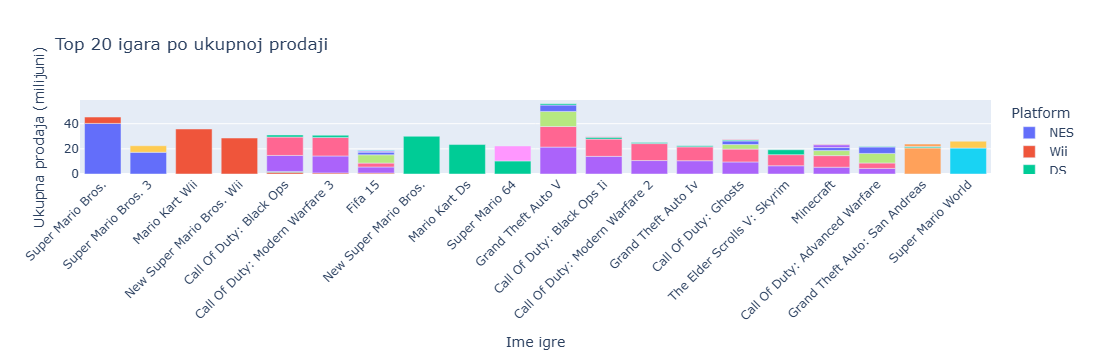

Ovaj graf prikazuje ukupnu prodaju top 20 igara po platformama. Na X-osi nalaze se imena igara, dok Y-os prikazuje ukupnu prodaju izraženu u milijunima primjeraka. Boje u grafu predstavljaju različite platforme, omogućujući analizu popularnosti igara na specifičnim uređajima. Dodatno, graf uključuje usporedbu između PC-a i konzola, kao i ostalih platformi, čime se jasno ističe dominacija konzola u odnosu na PC kada je riječ o ukupnoj prodaji igara. Kod konzola se posebice ističu platforme PlayStation 3 (PS3) i Xbox 360 (X360), koje su najzastupljenije među najprodavanijim igrama. Ovaj prikaz omogućuje lako uočavanje razlika u popularnosti igara između platformi te naglašava ulogu konzola kao glavnih nositelja prodaje igara, dok je PC zastupljen u znatno manjoj mjeri. Ostale platforme, poput prijenosnih konzola, također su uključene, ali njihov doprinos prodaji je znatno manji u usporedbi s glavnim konzolama PS3 i X360. Analiza ovih podataka pruža uvid u tržišne trendove, ukazujući na t

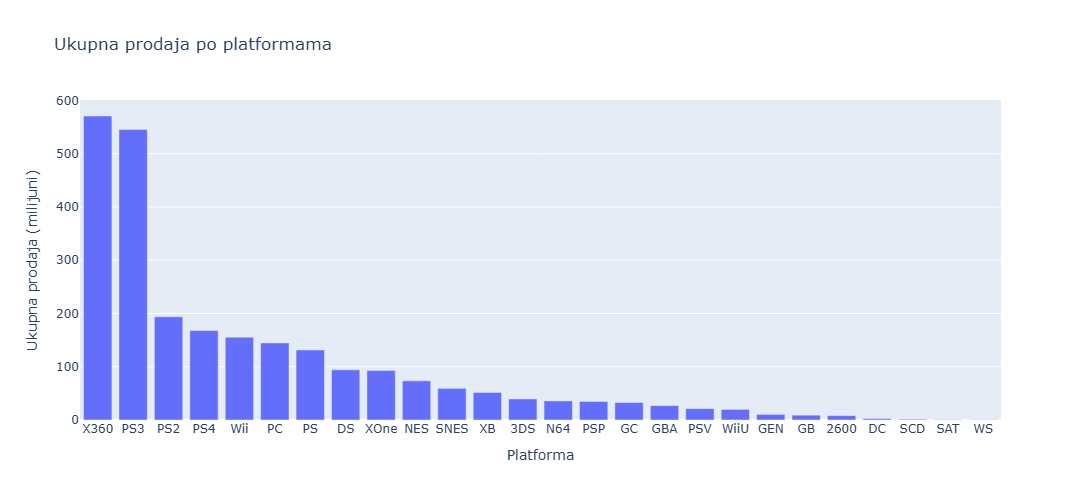

Ovaj graf prikazuje ukupnu prodaju igara po platformama. Na X osi su prikazane platforme (npr. PS3, Xbox, PC), dok Y os prikazuje ukupnu prodaju u milijunima primjeraka. Graf pomaže u razumijevanju koje platforme imaju najveći udio u ukupnoj prodaji. Te kao što i možemo vidjeti konzole uvelike prevladavaju nad računalima u popularnosti te kupnji igara.


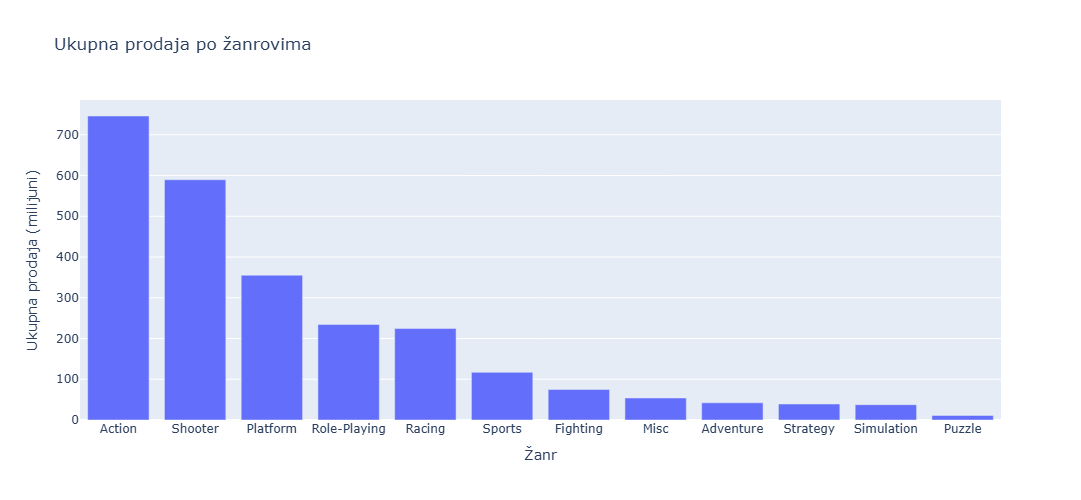

Ovaj graf prikazuje ukupnu prodaju po žanrovima igara. Na X osi su prikazani žanrovi igara (npr. Akcija, Avantura, Sport), dok Y os prikazuje ukupnu prodaju u milijunima primjeraka. Ovo pomaže u razumijevanju koji žanrovi igara dominiraju na tržištu prema ukupnoj prodaji. Zanimljivost je da u action žanru gotovo 90% prodanih igrica pripadaju PS3 i X360.


In [16]:
# Kreiranje FastAPI instance
app = FastAPI()

# Povezivanje na bazu podataka -- os koristio da nadem gdje mi je direktorij
DATABASE_PATH = os.path.join(os.getcwd(), "igre_baza.db")
engine = create_engine(f"sqlite:///{DATABASE_PATH}")

# Funkcija za dohvaćanje podataka iz baze
def fetch_data():
    with engine.connect() as connection:
        query = "SELECT Name, Platform, Genre, Global_Sales FROM igre"
        df = pd.read_sql(query, connection)
    return df

# poruka ako odem na root da znam da radi
@app.get("/")
def read_root():
    return {"message": "Dobrodošli u REST API!"}

# dohvacanje svega iz baze kroz api
@app.get("/igre/")
def get_all_igre():
    try:
        with engine.connect() as connection:
            query = text("SELECT * FROM igre")
            result = connection.execute(query).fetchall() 
            data = [dict(row._mapping) for row in result]  # pretvaranje u listu rijecnika jer mi baca neki error nezz zast
        return {"igre": data}
    except Exception as e:
        logging.error(f"Greška prilikom dohvaćanja podataka: {str(e)}")
        return {"error": str(e)}

# ako odem na dokumentaciju da mogu dobit po id igrice i ostalo --- DA ZNAM DA RADI ISPRAVNO
@app.get("/igre/{id}")
def get_igra_by_id(id: int):
    try:
        with engine.connect() as connection:
            query = text("SELECT * FROM igre WHERE id = :id")
            result = connection.execute(query, {"id": id}).fetchone()
            if result:
                return {"igra": dict(result._mapping)}  # opet u rjecnik
            else:
                return {"error": "Igra nije pronađena."}
    except Exception as e:
        logging.error(f"Greška prilikom dohvaćanja igre ID {id}: {str(e)}")
        return {"error": str(e)}

def start_fastapi():
    uvicorn.run(app, host="127.0.0.1", port=8000)

# pokrenuo fast api u posebnoj lokaciji jer imam neki sukob za port
thread = Thread(target=start_fastapi, daemon=True)
thread.start()

data = fetch_data()

game_platform_sales = data.groupby(['Name', 'Platform'], as_index=False)['Global_Sales'].sum()
game_platform_sales['Name'] = game_platform_sales['Name'].str.strip().str.lower().str.title() 
game_platform_sales = game_platform_sales.sort_values(by='Global_Sales', ascending=False)
print("Tablicni prikaz ukupne prodaje igara:")
display(game_platform_sales)

top_20_games = game_platform_sales.groupby('Name', as_index=False).sum().nlargest(20, 'Global_Sales')
fig1 = px.bar(
    game_platform_sales[game_platform_sales['Name'].isin(top_20_games['Name'])],
    x='Name',
    y='Global_Sales',
    color='Platform',
    title="Top 20 igara po ukupnoj prodaji",
    labels={'Global_Sales': 'Ukupna prodaja (milijuni)', 'Name': 'Ime igre'},
    height=600
)
fig1.update_layout(xaxis_tickangle=-45)
fig1.show()

print("Ovaj graf prikazuje ukupnu prodaju top 20 igara po platformama. Na X-osi nalaze se imena igara, dok Y-os prikazuje ukupnu prodaju izraženu u milijunima primjeraka. Boje u grafu predstavljaju različite platforme, omogućujući analizu popularnosti igara na specifičnim uređajima. Dodatno, graf uključuje usporedbu između PC-a i konzola, kao i ostalih platformi, čime se jasno ističe dominacija konzola u odnosu na PC kada je riječ o ukupnoj prodaji igara. Kod konzola se posebice ističu platforme PlayStation 3 (PS3) i Xbox 360 (X360), koje su najzastupljenije među najprodavanijim igrama. Ovaj prikaz omogućuje lako uočavanje razlika u popularnosti igara između platformi te naglašava ulogu konzola kao glavnih nositelja prodaje igara, dok je PC zastupljen u znatno manjoj mjeri. Ostale platforme, poput prijenosnih konzola, također su uključene, ali njihov doprinos prodaji je znatno manji u usporedbi s glavnim konzolama PS3 i X360. Analiza ovih podataka pruža uvid u tržišne trendove, ukazujući na to koje platforme dominiraju tržištem i koje su igre ključne za njihov uspjeh, ali bitno je primjetiti da su ovo igrice koje su izlazile prije 10-ak godina.")

platform_sales = data.groupby('Platform', as_index=False)['Global_Sales'].sum().sort_values(by='Global_Sales', ascending=False)
fig2 = px.bar(
    platform_sales,
    x='Platform',
    y='Global_Sales',
    title="Ukupna prodaja po platformama",
    labels={'Global_Sales': 'Ukupna prodaja (milijuni)', 'Platform': 'Platforma'},
    height=500
)
fig2.show()

print("Ovaj graf prikazuje ukupnu prodaju igara po platformama. Na X osi su prikazane platforme (npr. PS3, Xbox, PC), dok Y os prikazuje ukupnu prodaju u milijunima primjeraka. Graf pomaže u razumijevanju koje platforme imaju najveći udio u ukupnoj prodaji. Te kao što i možemo vidjeti konzole uvelike prevladavaju nad računalima u popularnosti te kupnji igara.")

genre_sales = data.groupby('Genre', as_index=False)['Global_Sales'].sum().sort_values(by='Global_Sales', ascending=False)
fig3 = px.bar(
    genre_sales,
    x='Genre',
    y='Global_Sales',
    title="Ukupna prodaja po žanrovima",
    labels={'Global_Sales': 'Ukupna prodaja (milijuni)', 'Genre': 'Žanr'},
    height=500
)
fig3.show()

print("Ovaj graf prikazuje ukupnu prodaju po žanrovima igara. Na X osi su prikazani žanrovi igara (npr. Akcija, Avantura, Sport), dok Y os prikazuje ukupnu prodaju u milijunima primjeraka. Ovo pomaže u razumijevanju koji žanrovi igara dominiraju na tržištu prema ukupnoj prodaji. Zanimljivost je da u action žanru gotovo 90% prodanih igrica pripadaju PS3 i X360.")



Te na kraju prikaz rada aplikacije. Tako što dohvaćamo podatke iz tablice igre uz pomoć REST API-a tako što idemo na novu stranicu u pregledniku te unosimo: http://127.0.0.1:8000/igre/ ili mozemo koristiti http://127.0.0.1:8000/docs kako bi smo imali ljepši pregled i mogučnosti.

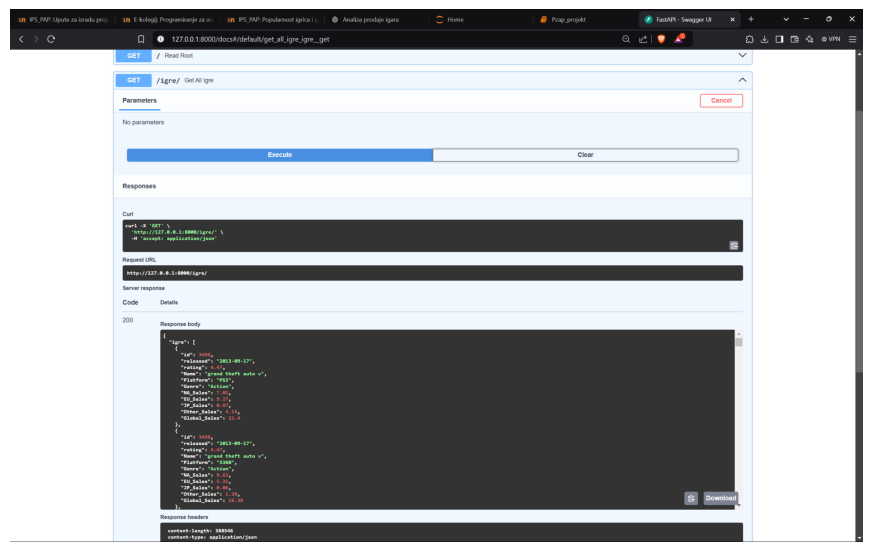

In [17]:
image_path = "a.png"  
img = mpimg.imread(image_path)
plt.figure(figsize=(11, 11)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

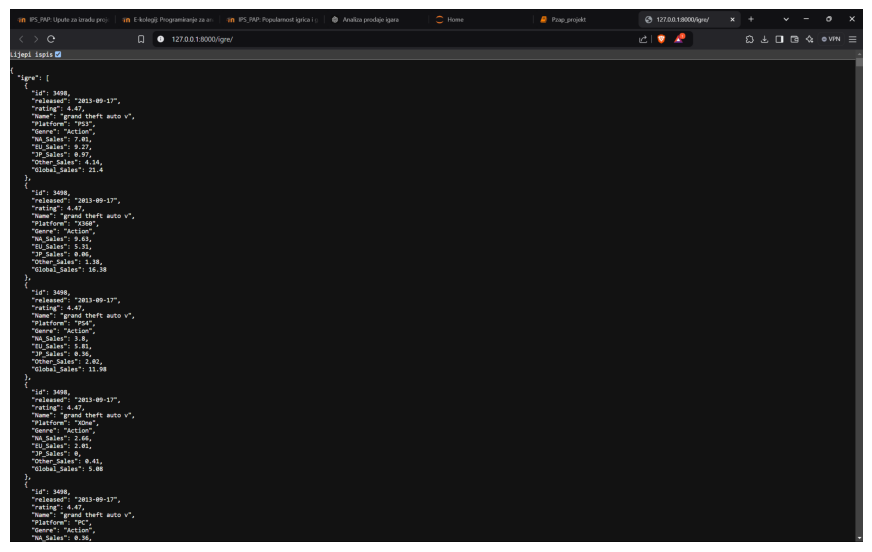

In [18]:
image_path = "b.png"  
img = mpimg.imread(image_path)
plt.figure(figsize=(11, 11))  
plt.imshow(img)
plt.axis('off')  
plt.show()

## Kritički osvrt

Praktična izvedivost i primjena ove aplikacije, koja povezuje FastAPI s bazom podataka, omogućuju učinkovito upravljanje i analizu podataka o igrama. Aplikacija je jednostavna za implementaciju i proširivanje, budući da FastAPI pruža visoke performanse, a SQLite je lagana i lako postavljiva baza podataka koja omogućuje brzu pohranu i dohvaćanje podataka. Korištenje SQL upita za pristup podacima i njihovo filtriranje omogućuje detaljnu analizu, dok integracija s Plotly omogućuje vizualizaciju podataka na interaktivan način. Ova kombinacija alata pokazuje visoku fleksibilnost i skalabilnost, ali je ograničena u smislu performansi kada je riječ o većim količinama podataka ili zahtjevnijim aplikacijama koje zahtijevaju veće baze podataka. Također, aplikacija bi mogla profitirati od dodatne optimizacije u pogledu obrade podataka i boljeg upravljanja pogreškama.

## Zaključak

Aplikacija razvijena u ovom projektu omogućuje učinkovitu analizu podataka o globalnoj prodaji igara na različitim platformama i žanrovima. Korištenje FastAPI-ja omogućuje lako proširivanje i interakciju s bazom podataka putem API-ja, dok vizualizacija podataka pomaže korisnicima da bolje razumiju tržišne trendove. Iako je projekt tehnički izvediv i korisno demonstrira osnovne principe rada s bazama podataka i vizualizacijama, daljnje usmjerenje na optimizaciju i implementaciju naprednijih funkcionalnosti moglo bi dodatno povećati njegovu učinkovitost i primjenjivost u stvarnim poslovnim scenarijima.

## Literatura

[1] M. Grinberg, FastAPI: The fastest way to build APIs with Python 3.6+, O'Reilly Media, 2018.

[2] "SQLAlchemy Documentation," SQLAlchemy, [Online]. Available: https://www.sqlalchemy.org/. [Accessed: Jan. 2025].

[3] Plotly, Interactive Graphing and Data Visualization, [Online]. Available: https://plotly.com/. [Accessed: Jan. 2025].

[4] Python Software Foundation, "SQLite3 module documentation," [Online]. Available: https://docs.python.org/3/library/sqlite3.html. [Accessed: Jan. 2025].

[5] OpenAI, ChatGPT: Prompt razgovora s CHAT-GPT-om: https://chatgpt.com/share/67952534-c704-800e-bb96-e02ec2b233f4  Available: https://chat.openai.com/. [Accessed: Jan. 2025].